### Klassificering med pytorch

In [27]:
#Setup
import torch
import torchvision
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchmetrics
device = "cuda"
n_epochs=20

In [28]:
def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()  # reset the metric at the beginning
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)  # update it at each iteration
    return metric.compute()  # compute the final result at the en

def train(model, optimizer, criterion, metric, train_loader, val_loader,
               n_epochs):
    history = {"train_losses": [], "train_metrics": [], "val_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.
        metric.reset()
        for X_batch, y_batch in train_loader:
            model.train()
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        mean_loss = total_loss / len(train_loader)
        history["train_losses"].append(mean_loss)
        history["train_metrics"].append(metric.compute().item())
        history["val_metrics"].append(
            evaluate_tm(model, val_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"val metric: {history['val_metrics'][-1]:.4f}")
    return history

In [29]:
toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_val_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

train_data, val_data = torch.utils.data.random_split(train_and_val_data, [55000, 5000])

In [30]:
train_loader = DataLoader(train_data, batch_size=32,
                          shuffle=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(val_data, batch_size=32, pin_memory=True,num_workers=8)
test_loader = DataLoader(test_data, batch_size=32, num_workers=8, pin_memory=True)

In [31]:
X_sample, y_sample = train_data[0]

In [32]:
train_and_val_data.classes[y_sample]

'Coat'

In [33]:
class ImageClassifier(nn.Module):
    def __init__(self, n_inputs, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_inputs, n_hidden1, n_hidden2),
            nn.ReLU(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.ReLU(),
            nn.Linear(n_hidden2, n_classes)
        )
    
    def forward(self, X):
        return self.mlp(X)

In [34]:
model = ImageClassifier(n_inputs=28*28, n_hidden1=200,n_hidden2=200,n_classes=10).to(device)
xentropy = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=10).to(device)
history = train(model, optimizer, xentropy, accuracy, train_loader, val_loader, 30)

Epoch 1/30, train loss: 0.5035, train metric: 0.8164, val metric: 0.8638
Epoch 2/30, train loss: 0.3693, train metric: 0.8639, val metric: 0.8672
Epoch 3/30, train loss: 0.3303, train metric: 0.8786, val metric: 0.8772
Epoch 4/30, train loss: 0.3054, train metric: 0.8856, val metric: 0.8840
Epoch 5/30, train loss: 0.2895, train metric: 0.8918, val metric: 0.8852
Epoch 6/30, train loss: 0.2738, train metric: 0.8980, val metric: 0.8882
Epoch 7/30, train loss: 0.2591, train metric: 0.9022, val metric: 0.8926
Epoch 8/30, train loss: 0.2479, train metric: 0.9078, val metric: 0.8890
Epoch 9/30, train loss: 0.2367, train metric: 0.9118, val metric: 0.8944
Epoch 10/30, train loss: 0.2256, train metric: 0.9139, val metric: 0.8956
Epoch 11/30, train loss: 0.2185, train metric: 0.9167, val metric: 0.8866
Epoch 12/30, train loss: 0.2114, train metric: 0.9197, val metric: 0.8942
Epoch 13/30, train loss: 0.2014, train metric: 0.9239, val metric: 0.9022
Epoch 14/30, train loss: 0.1947, train metric: 

In [35]:
model.eval()
X_new, y_new = next(iter(val_loader))
X_new = X_new[:3].to(device)
with torch.no_grad():
    y_hat_logits = model(X_new)
y_pred = y_hat_logits.argmax(dim=1)
y_pred

tensor([0, 6, 8], device='cuda:0')

In [36]:
[train_and_val_data.classes[index] for index in y_pred]

['T-shirt/top', 'Shirt', 'Bag']

In [37]:
y_new[:3]

tensor([0, 6, 8])

              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      1000
         1.0       0.98      0.98      0.98      1000
         2.0       0.85      0.70      0.77      1000
         3.0       0.95      0.81      0.87      1000
         4.0       0.66      0.93      0.77      1000
         5.0       0.99      0.90      0.94      1000
         6.0       0.71      0.59      0.65      1000
         7.0       0.95      0.94      0.95      1000
         8.0       0.96      0.97      0.97      1000
         9.0       0.90      0.98      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



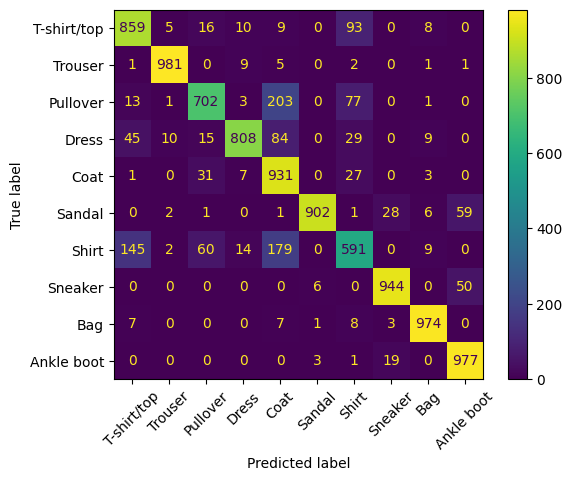

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
X_test, y_test = test_data.data.float(), test_data.targets.float()
X_test = X_test.to(device)
y_test = y_test.to(device)
with torch.no_grad():
    y_hat = model(X_test)
y_pred = y_hat.argmax(dim=1)
print(classification_report(y_test.cpu(), y_pred.cpu()))
cm = confusion_matrix(y_test.cpu(),y_pred.cpu())
ConfusionMatrixDisplay(cm,display_labels=test_data.classes).plot(xticks_rotation=45)